In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
sns.set()
np.random.seed(42)

### Defining Quadratic Assignment problem

The objective of the Quadratic Assignment Problem (QAP) is to assign n facilities to n locations in such a way as to minimize the assignment cost. The assignment cost is the sum, over all pairs, of the flow between a pair of facilities multiplied by the distance between their assigned locations

In [2]:
facility = ['A','B','C','D','E','F','G','H',]
location = ['L1','L2','L3','L4','L5','L6','L7','L8']

distance_df = pd.DataFrame([[0,1,2,3,1,2,3,4],[1,0,1,2,2,1,2,3],[2,1,0,1,3,2,1,2],
                            [3,2,1,0,4,3,2,1],[1,2,3,4,0,1,2,3],[2,1,2,3,1,0,1,2],
                            [3,2,1,2,2,1,0,1],[4,3,2,1,3,2,1,0]],
                           columns=location,index=location)

frequency_df = pd.DataFrame([[0,5,2,4,1,0,0,6],[5,0,3,0,2,2,2,0],[2,3,0,0,0,0,0,5],
                             [4,0,0,0,5,2,2,10],[1,2,0,5,0,10,0,0],[0,2,0,2,10,0,5,1],
                             [0,2,0,2,0,5,0,10],[6,0,5,10,0,1,10,0]],
                            columns=facility,index=facility)

In [3]:
def get_fitness_value(chromosome,distance_df,frequency_df):
    size = len(distance_df.columns)
    lower_idx = np.tril_indices(size, -1)     #lower triangle matrix indices
    assign = frequency_df.reindex(index=chromosome,columns=chromosome)
    cost = distance_df.values * assign.values
    cost = np.sum(cost[lower_idx])
    return cost

def get_family(parents_idx,fitness_values):
    # select best parent from k candidates
    values = fitness_values[parents_idx]  
    select_idx = np.argsort(values)[0]
    return parents_idx[select_idx]

def cross_over(parents,pop,prob_crs_ovr=1):
    # get parents chromosome from population
    parent_1 = pop[parents[0]]
    parent_2 = pop[parents[1]]
    
    
    # cross over if random is less than probability of cross over
    random =  np.random.rand()
  
    if random < prob_crs_ovr:
         # create position for two point cross over
        idx_1 = np.random.randint(0,len(parent_1))
        idx_2 = np.random.randint(0,len(parent_2))

        # position 1 and position 2 should not be equal
        while idx_1 == idx_2:
            idx_2 = np.random.randint(0,len(parent_2))

        # position 1 should be before position 2
        if idx_1 < idx_2:
            pos_1 = idx_1
            pos_2 = idx_2
        else:
            pos_1 = idx_2
            pos_2 = idx_1
    
        # create children 1 by replicating middle part of parent 1 into parent 2
        p1_mid = parent_1[pos_1:pos_2]
        child_1 = np.copy(parent_2)
        p1_idx = pos_1
        for gene in p1_mid:
            
            # find gene position in parent 2
            p2_idx = np.where(parent_2 == gene)[0][0] 
            
            # put gene in same as position in parent 2 as in parent 1
            # swap the values in parent 2 where gene needs to go with where gene is currently present
            child_1[[p1_idx,p2_idx]] =child_1[[p2_idx,p1_idx]] 
           
            # increment p1_idx
            p1_idx = p1_idx+1
    
        # create children 2 by replicating middle part of parent 2 into parent 1
        p2_mid = parent_2[pos_1:pos_2]
        child_2 = np.copy(parent_2)
        p2_idx = pos_1
        for gene in p2_mid:
            
            # find gene position in parent 1
            p1_idx = np.where(parent_1 == gene)[0][0] 
            
            # put gene in same as position in parent 1 as in parent 2
            # swap the values in parent 1 where gene needs to go with where gene is currently present
            child_1[[p2_idx,p1_idx]] =child_1[[p1_idx,p2_idx]] 
           
            # increment p1_idx
            p2_idx = p2_idx+1
            
    else:
        child_1 = parent_1
        child_2 = parent_2
    
    return np.array([child_1,child_2])     

def mutation(child,p_mutate):
    # mutate gene where random number is less 0.2
    random = np.random.rand()
    if random < p_mutate:
        # create position for mutation between two points
        idx_1 = np.random.randint(0,len(child))
        idx_2 = np.random.randint(0,len(child))

        # position 1 and position 2 should not be equal
        while idx_1 == idx_2:
            idx_2 = np.random.randint(0,len(child))
            
        # position 1 should be before position 2
        if idx_1 < idx_2:
            pos_1 = idx_1
            pos_2 = idx_2
        else:
            pos_1 = idx_2
            pos_2 = idx_1
            
        # reverse the position between position 1 and position 2
        child[pos_1:pos_2] = np.flip(child[pos_1:pos_2])
                                     
    return child                                     

In [4]:
p_mutation = 0.2        # Probability of mutation
k = 3                   # For Tournament selection
n_pop = 100             # Population per generation
n_gen = 50              # Number of generations

gen_sol = []
gen_value = []

# Generate initial population by replicating facility into n_pop dimension
pop = np.tile(facility, (n_pop,1))

# Random shuffle the solutions
np.apply_along_axis(np.random.shuffle,1,pop)

for gen in range(n_gen):
    # compute fitness value for each chromosome
    all_cost = np.apply_along_axis(get_fitness_value,1,pop,distance_df=distance_df,frequency_df=frequency_df)
    
    # find index for minimum value
    best_idx = np.argmin(all_cost)
    
    # store best solution and best value for this generation
    gen_sol.append(pop[best_idx])
    gen_value.append(all_cost[best_idx])
    
    # select k candidate for mutation for n_pop times
    candidates = np.random.choice(np.arange(0,n_pop),n_pop*k).reshape(n_pop,k)
    
    # Get the best parent from the candidates
    family = np.apply_along_axis(get_family,1,candidates,fitness_values=all_cost)
    
    # reshaping to get two parent to produce two child
    parents = family.reshape(int(n_pop/2),2)
    
    # create new population by crossover
    new_pop = np.apply_along_axis(cross_over,1,parents,pop=pop)

    # new population will be three dimensional array
    # convert 3D array to 2D array
    pop = np.vstack((new_pop[:,0,:],new_pop[:,1,:]))   
    
    # mutate child
    pop = np.apply_along_axis(mutation,1,pop,p_mutate=p_mutation)
    
# choose the best value and best solution obtained from all generations 
best_idx = np.argmin(gen_value)
best_min = gen_value[best_idx]
chromosome = gen_sol[best_idx]
print('Best Solution occus in gen {} for sequence = {} and obj value {}'.format(best_idx,chromosome,best_min))     

Best Solution occus in gen 1 for sequence = ['C' 'H' 'G' 'F' 'B' 'A' 'D' 'E'] and obj value 107


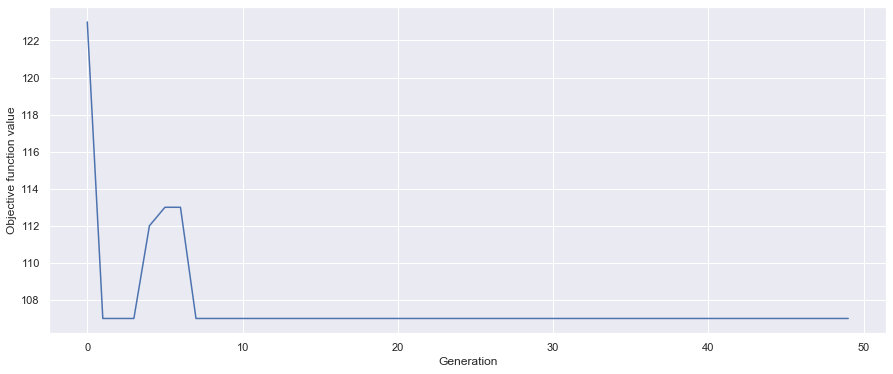

In [5]:
plt.figure(figsize=(15,6))
plt.xlabel('Generation')
plt.ylabel('Objective function value')
plt.plot(range(n_gen),gen_value)